<a href="https://colab.research.google.com/github/Joana123-collab/Data-Science/blob/main/Proyecto_Data_Science_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicción de empresas en quiebra 🏦
Para este análisis se utilizó un dataset público obtenido de Kaggle, que contiene información financiera detallada de empresas, incluyendo 95 indicadores financieros. Estos indicadores abarcan métricas de rentabilidad (como el ROA), liquidez (como el ratio de liquidez corriente), apalancamiento y otros parámetros contables relevantes.

➡ El objetivo es analizar si estas variables permiten anticipar la probabilidad de quiebra de una empresa, dado que esto es algo crítico para bancos, inversores y reguladores.


🧑 Audiencia:

-Inversores: Les permitirá identificar empresas de alto riesgo.

-Reguladores: Monitorear estabilidad financiera sectorial.

✍Problema:

Problema Principal
➡Clasificación Binaria: Predecir si una empresa entrará en quiebra (¿En quiebra? = 1) usando métricas financieras.

Problema Secundario: Identificar los factores económicos más críticos (análisis de importancia de features).


🎯Objetivo:

Construir un modelo de clasificación que identifique empresas en riesgo con un Recall > 85% (priorizando detectar la mayor cantidad de quiebras posibles).

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# Enlace público de Github
url= "https://github.com/Joana123-collab/Data-Science/raw/refs/heads/main/DISTRESSDATASET_DATASCIENCE.csv"
df = pd.read_csv(url, on_bad_lines= 'skip', sep=',', encoding='latin-1')

# Mostramos las primeras filas
print(df.head())


   ¿En quiebra?  \
0             1   
1             1   
2             1   
3             1   
4             1   

    ROA(C): Retorno sobre activos (antes de intereses y depreciación)  \
0                                           0.370594                    
1                                           0.464291                    
2                                           0.426071                    
3                                           0.399844                    
4                                           0.465022                    

    ROA(A): Retorno sobre activos (antes de impuestos)  \
0                                           0.424389     
1                                           0.538214     
2                                           0.499019     
3                                           0.451265     
4                                           0.538432     

    ROA(B): Retorno sobre activos (después de impuestos)  \
0                                    

# ▶ EDA Inicial


🔍 EDA INICIAL:
Shape: (6819, 97)

Tipos de datos:
 ¿En quiebra?                                                            int64
 ROA(C): Retorno sobre activos (antes de intereses y depreciación)    float64
 ROA(A): Retorno sobre activos (antes de impuestos)                   float64
 ROA(B): Retorno sobre activos (después de impuestos)                 float64
 Margen bruto operativo                                               float64
                                                                       ...   
 Pasivos/Patrimonio                                                   float64
 Grado de apalancamiento financiero (DFL)                             float64
 Cobertura de intereses (EBIT/Gastos financieros)                       int64
 Indicador de beneficio neto (Positivo/Negativo)                      float64
 Patrimonio/Pasivos                                                   float64
Length: 97, dtype: object

Primeras filas:
    ¿En quiebra?  \
0             1   
1       

<ipython-input-3-6fc95353a1f4>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='¿En quiebra?', data=df, palette=paleta_lila)


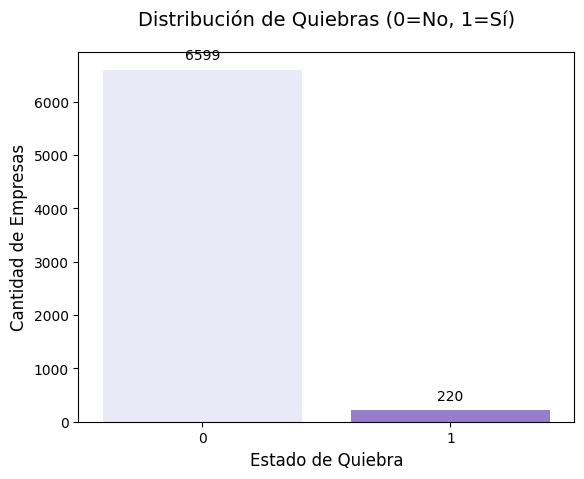

In [3]:
#Analisis inicial
print("\n🔍 EDA INICIAL:")
print("Shape:", df.shape)
print("\nTipos de datos:\n", df.dtypes)
print("\nPrimeras filas:\n", df.head())

#Analisis del target
print("\n📊 DISTRIBUCIÓN DEL TARGET (¿En quiebra?):")
print(df['¿En quiebra?'].value_counts(normalize=True))

# Gráfico de distribución del target
paleta_lila = {"0": "lavender", "1": "mediumpurple"}
ax = sns.countplot(x='¿En quiebra?', data=df, palette=paleta_lila)
for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height())}",  # Texto: valor de la barra (convertido a entero)
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posición (x, y)
        ha='center',  # Alineación horizontal centrada
        va='center',  # Alineación vertical centrada
        xytext=(0, 10),  # Desplazamiento del texto respecto a la posición
        textcoords='offset points',  # Tipo de coordenadas para xytext
        fontsize=10,  # Tamaño de fuente
        color='black'  # Color del texto
    )

plt.title("Distribución de Quiebras (0=No, 1=Sí)", fontsize=14, pad=20)
plt.xlabel("Estado de Quiebra", fontsize=12)
plt.ylabel("Cantidad de Empresas", fontsize=12)


print("\nProporción de quiebras:\n", df['¿En quiebra?'].value_counts(normalize=True))

plt.show()


Revisión de nulos:
Patrimonio/Pasivos    100.0
dtype: float64


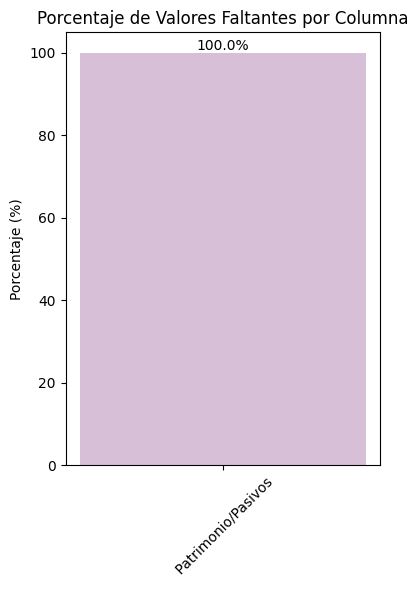

Shape original: (6819, 97)
Shape después de limpieza: (6819, 96)
Columna eliminada: [' Patrimonio/Pasivos']


In [4]:
# Revisión de nulos
print("Revisión de nulos:")
null_pct = df.isnull().mean() * 100
null_pct = null_pct[null_pct > 0]

if null_pct.empty:
    print("No se encontraron valores nulos en las columnas.")
else:
    print(null_pct)  # Opcional: mostrar % de nulos por columna

    # Gráfico si hay nulos
    plt.figure(figsize=(4, 6))
    lila_pastel = (216/255, 191/255, 216/255)
    bars = plt.bar(null_pct.index, null_pct, color=lila_pastel)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.1f}%', ha='center', va='bottom')

    plt.title('Porcentaje de Valores Faltantes por Columna')
    plt.xticks(rotation=45)
    plt.ylabel('Porcentaje (%)')
    plt.tight_layout()
    plt.show()

#Buscamos y eliminamos columnas nulas
# Dataset original
print("Shape original:", df.shape)

# Eliminar columna
df_clean = df.drop(columns=[' Patrimonio/Pasivos'], errors='ignore')

# Verificación
print("Shape después de limpieza:", df_clean.shape)
print("Columna eliminada:", list(set(df.columns) - set(df_clean.columns)))



Top 15 variables correlacionadas con quiebra:
 Indicador de riesgo (Pasivos > Activos)                              0.315457
ROA(A): Retorno sobre activos (antes de impuestos)                   0.282941
ROA(B): Retorno sobre activos (después de impuestos)                 0.273051
ROA(C): Retorno sobre activos (antes de intereses y depreciación)    0.260807
Nivel de endeudamiento (%)                                           0.250161
Deuda total/Patrimonio neto                                          0.250161
EPS persistente (últimos 4 trimestres)                               0.219560
Pasivos a largo plazo/Activos corrientes                             0.217779
Beneficio operativo/Capital pagado                                   0.207857
Beneficio neto por acción (antes de impuestos                        0.201395
Efectivo/Pasivos corrientes                                          0.194494
% de asignación por empleado                                         0.193083
Margen bruto/Ven

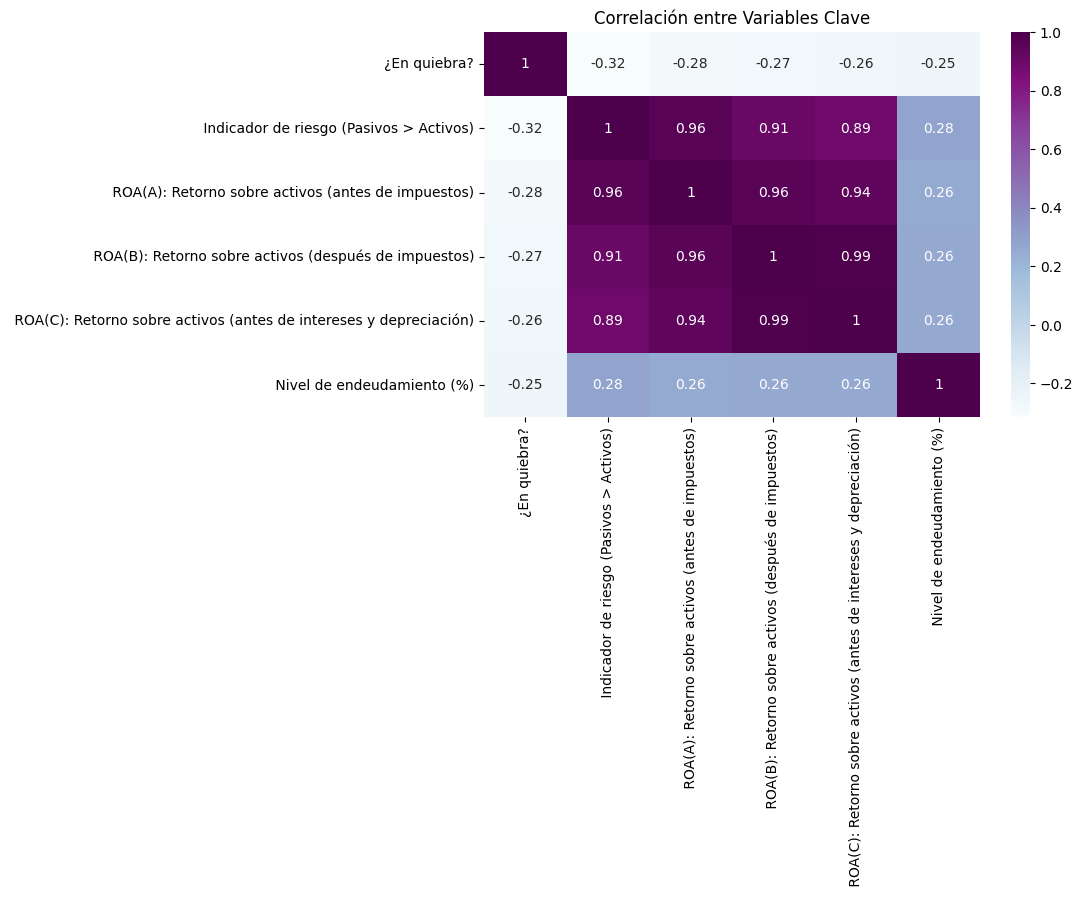

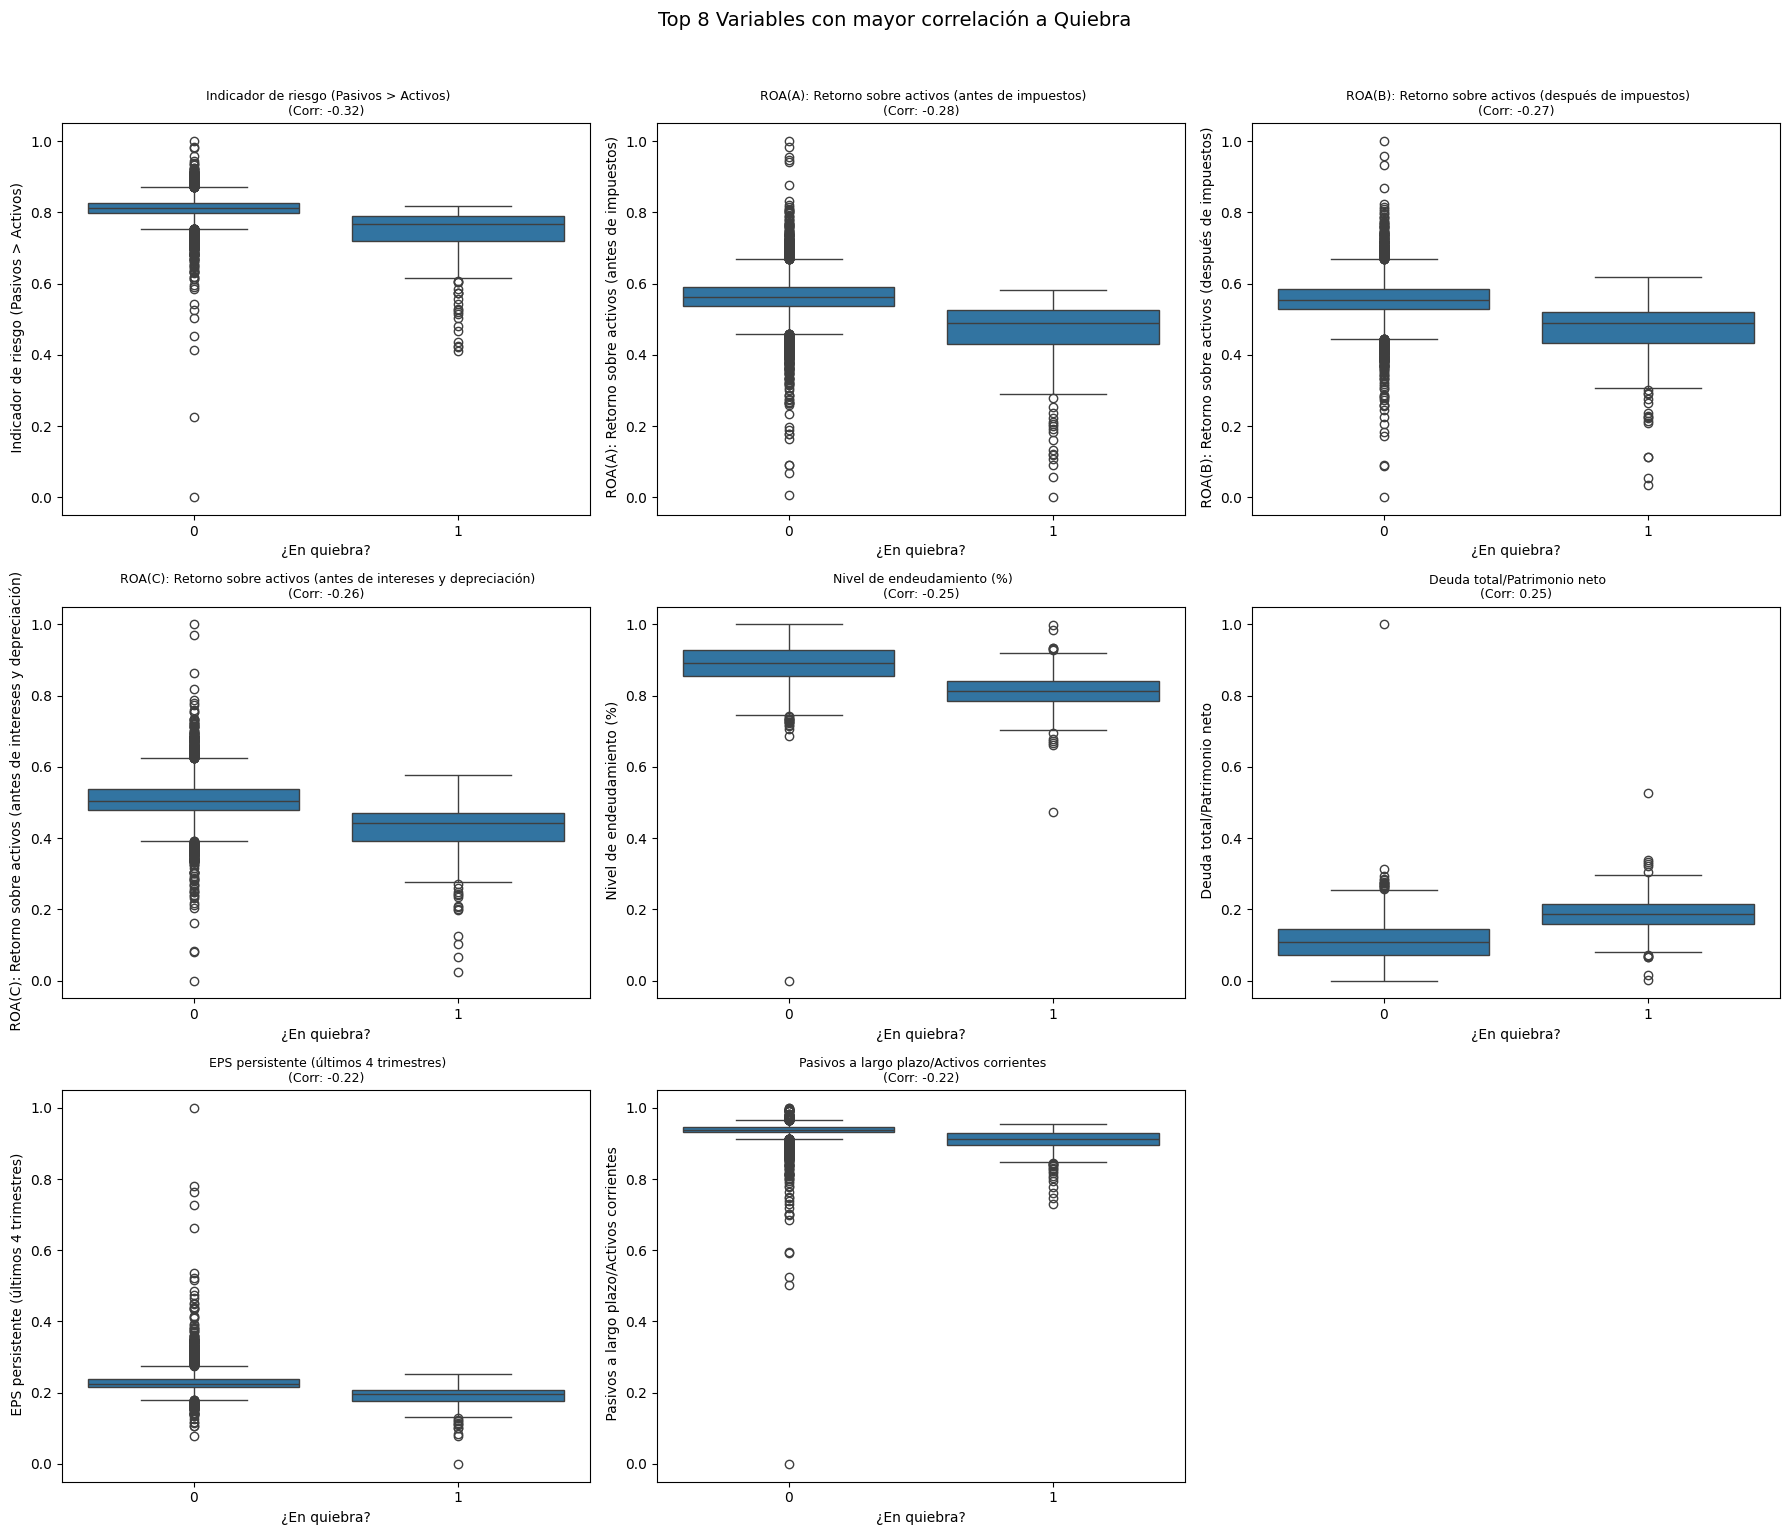

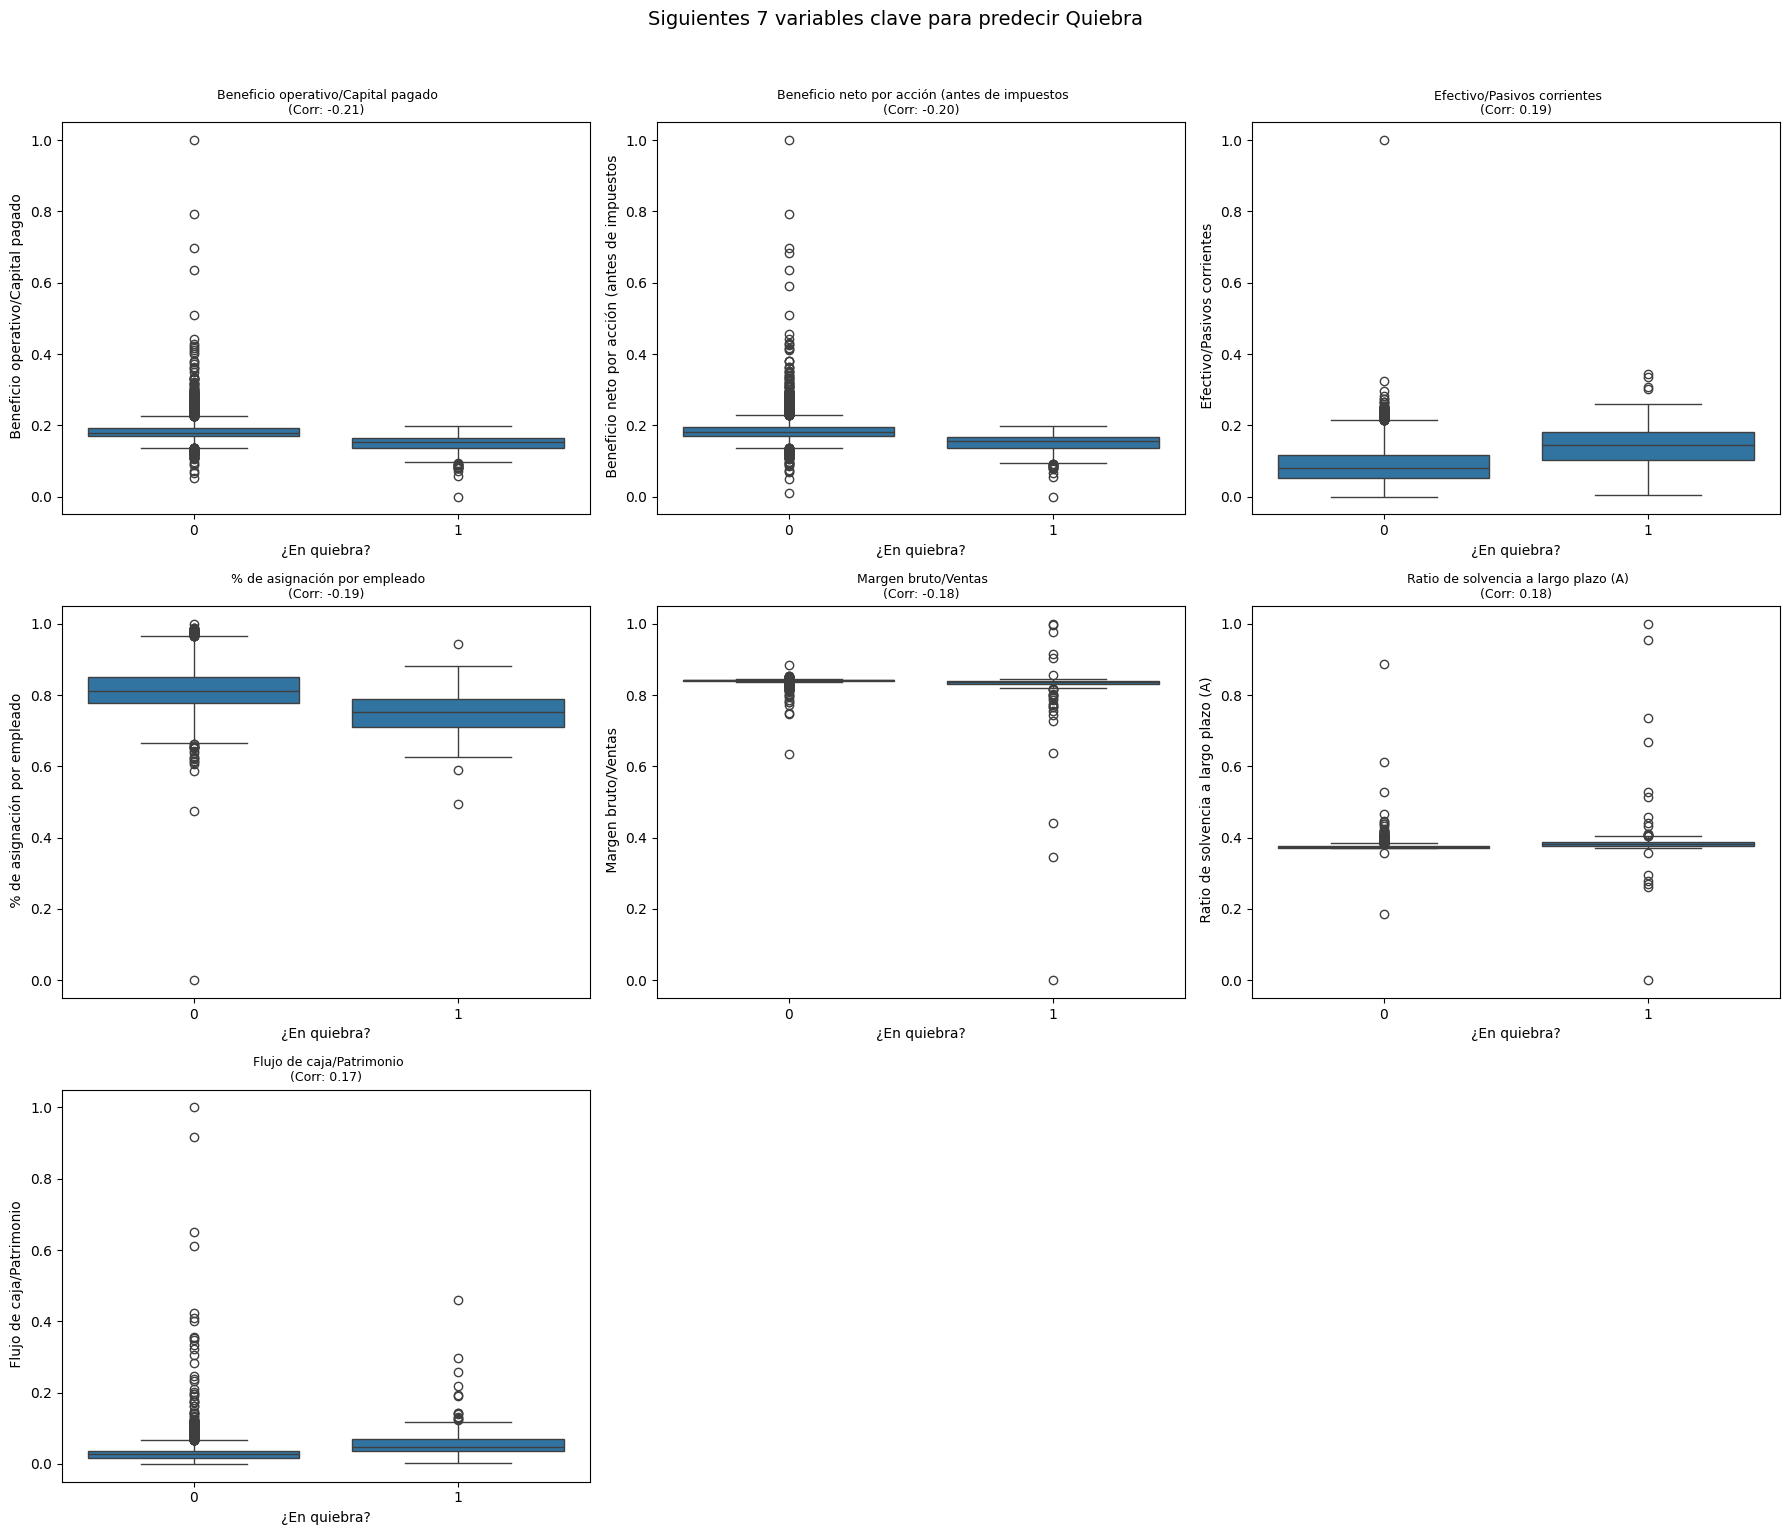

Columnas completamente nulas: [' Patrimonio/Pasivos']
Se eliminaron 1 columnas nulas.


In [5]:
#Top 15 variables correlacionadas con quiebra
corr_target = df.corr()['¿En quiebra?'].abs().sort_values(ascending=False)
print("\nTop 15 variables correlacionadas con quiebra:\n", corr_target[1:16])  # Excluye la variable objetivo

# Heatmap de correlaciones
plt.figure(figsize=(8, 5))
sns.heatmap(df[corr_target.index[:6]].corr(), annot=True, cmap='BuPu')
plt.title("Correlación entre Variables Clave");

#Distribuimos variables clave
#Recordemos las 15 variables ordenadas por correlación que recien obtuvimos
top_15_vars = [
    ' Indicador de riesgo (Pasivos > Activos)',
    ' ROA(A): Retorno sobre activos (antes de impuestos)',
    ' ROA(B): Retorno sobre activos (después de impuestos)',
    ' ROA(C): Retorno sobre activos (antes de intereses y depreciación)',
    ' Nivel de endeudamiento (%)',
    ' Deuda total/Patrimonio neto',
    ' EPS persistente (últimos 4 trimestres)',
    ' Pasivos a largo plazo/Activos corrientes',
    ' Beneficio operativo/Capital pagado',
    ' Beneficio neto por acción (antes de impuestos',
    ' Efectivo/Pasivos corrientes',
    ' % de asignación por empleado',
    ' Margen bruto/Ventas',
    ' Ratio de solvencia a largo plazo (A)',
    ' Flujo de caja/Patrimonio'
]

# Dividimos las variables en 2 grupos para 2 figuras
grupo1 = top_15_vars[:8]  # Primera figura: 8 variables (3x3)
grupo2 = top_15_vars[8:]  # Segunda figura: 7 variables (3x3)

# Función para generar los plots
def plot_variables(variables, title):
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.ravel()
    for i, var in enumerate(variables):
        sns.boxplot(x='¿En quiebra?', y=var, data=df, ax=axes[i])
        axes[i].set_title(f'{var}\n(Corr: {df[var].corr(df["¿En quiebra?"]):.2f})', fontsize=9)
    # Ocultar ejes vacíos
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Generar las figuras
plot_variables(grupo1, 'Top 8 Variables con mayor correlación a Quiebra')
plot_variables(grupo2, 'Siguientes 7 variables clave para predecir Quiebra')

#Le decimos al sisstema que identiifique y elimine cualquier columna con valores nulos, asi no tira errorrrr
null_cols = df.columns[df.isnull().all()].tolist()
print("Columnas completamente nulas:", null_cols)
if null_cols:
    df = df.drop(columns=null_cols)
    print(f"Se eliminaron {len(null_cols)} columnas nulas.")



# ▶ Feature engineering y Preprocesamiento

In [11]:
# Creamos nuevos features
df[' Liquidez vs Endeudamiento'] = df[' Ratio corriente'] / (df[' Deuda total/Patrimonio neto'] + 1e-6)
df[' Eficiencia Operativa'] = df[' Rotación de activos totales'] * df[' Margen bruto operativo']
df[' Solvencia Global'] = df[' Ratio corriente'] + df[' Ratio de solvencia a largo plazo (A)']

# Eliminamos columnas constantes (para evitar warnings)
constant_cols = [col for col in df.columns if df[col].nunique() == 1]
if constant_cols:
    df = df.drop(columns=constant_cols)
    print(f"Columnas constantes eliminadas: {constant_cols}")

# Reemplazamos infinitos (por si acaso)
df.replace([np.inf, -np.inf], np.nan, inplace=True)


Columnas constantes eliminadas: [' Cobertura de intereses (EBIT/Gastos financieros)']


# ▶ Separación de variables y manejo de datos faltantes

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

X = df.drop('¿En quiebra?', axis=1)
y = df['¿En quiebra?']

# Guardamos los nombres originales para mantenerlos luego
feature_names = X.columns

# Imputamos valores faltantes (media)
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=feature_names)


# ▶ Selección de Features

In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)
X_selected = selector.fit_transform(X_imputed, y)

# Obtenemos los nombres de las features seleccionadas
selected_features = feature_names[selector.get_support()]

# Convertimos a DataFrame con nombres de columnas
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

print("\nTop 20 features predictivas:\n", selected_features)



Top 20 features predictivas:
 Index([' ROA(C): Retorno sobre activos (antes de intereses y depreciación)',
       ' ROA(A): Retorno sobre activos (antes de impuestos)',
       ' ROA(B): Retorno sobre activos (después de impuestos)',
       ' Valor contable por acción (B)', ' Valor contable por acción (A)',
       ' Valor contable por acción (C)',
       ' EPS persistente (últimos 4 trimestres)',
       ' Beneficio neto por acción (antes de impuestos',
       ' Deuda total/Patrimonio neto', ' Nivel de endeudamiento (%)',
       ' Ratio de solvencia a largo plazo (A)',
       ' Beneficio operativo/Capital pagado', ' % de asignación por empleado',
       ' Efectivo/Pasivos corrientes',
       ' Pasivos a largo plazo/Activos corrientes',
       ' Pasivos corrientes/Pasivos totales.1', ' Flujo de caja/Patrimonio',
       ' Indicador de riesgo (Pasivos > Activos)', ' Margen bruto/Ventas',
       ' Beneficio neto/Patrimonio'],
      dtype='object')


# ▶ División en conjunto de entrenamiento y prueba

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_df,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# Balanceo con SMOTE y escalado

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

print("\n🔹 Distribución en y_train (ANTES de balanceo):")
print(y_train.value_counts(normalize=True))

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("\n🔹 Distribución en y_train_bal (DESPUÉS de SMOTE):")
print(pd.Series(y_train_bal).value_counts(normalize=True))

scaler = StandardScaler()
X_train_bal_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)



🔹 Distribución en y_train (ANTES de balanceo):
¿En quiebra?
0    0.967735
1    0.032265
Name: proportion, dtype: float64

🔹 Distribución en y_train_bal (DESPUÉS de SMOTE):
¿En quiebra?
0    0.5
1    0.5
Name: proportion, dtype: float64


# Entrenamiento con Random Forest usando Pipeline

In [29]:
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Pipeline de Random Forest con SMOTE
ImbPipeline=rf_pipeline= ImbPipeline(steps=[
    ('scaler', scaler),
    ('smote', SMOTE(random_state=42)),
    ('random_forest', RandomForestClassifier(random_state=42))
])

# Entrenamos el pipeline con los datos originales (sin balancear)
model_pipeline.fit(X_train, y_train)




Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(random_state=42))])

# Evaluación del modelo Random Forest


📊 Classification Report:
              precision    recall  f1-score   support

  No Quiebra       0.99      0.96      0.97      1980
     Quiebra       0.30      0.58      0.40        66

    accuracy                           0.94      2046
   macro avg       0.64      0.77      0.68      2046
weighted avg       0.96      0.94      0.95      2046


🧮 Confusion Matrix:
[[1893   87]
 [  28   38]]

✅ Accuracy: 0.9438 (94.38%)

📈 ROC-AUC Score: 0.9072


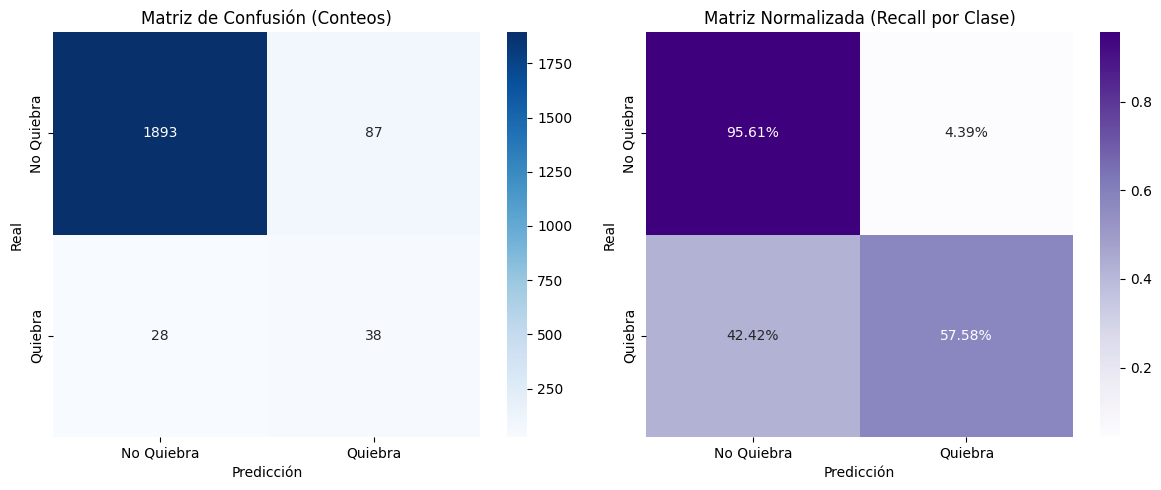

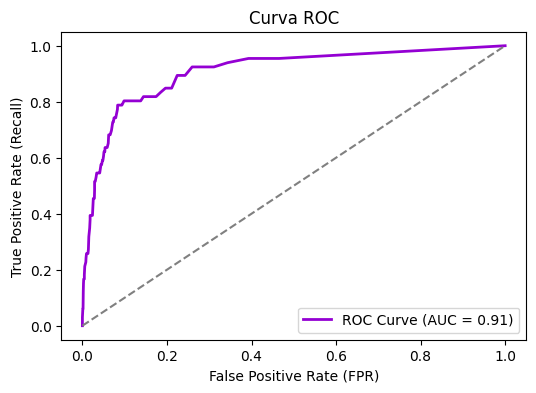

In [30]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

y_pred = model_pipeline.predict(X_test)
y_probs = model_pipeline.predict_proba(X_test)[:, 1]

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Quiebra", "Quiebra"]))

print("\n🧮 Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"\n✅ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")

# Gráficos
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["No Quiebra", "Quiebra"],
            yticklabels=["No Quiebra", "Quiebra"])
plt.title("Matriz de Confusión (Conteos)")
plt.xlabel("Predicción")
plt.ylabel("Real")

conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_norm,
            annot=True,
            fmt=".2%",
            cmap="Purples",
            xticklabels=["No Quiebra", "Quiebra"],
            yticklabels=["No Quiebra", "Quiebra"])
plt.title("Matriz Normalizada (Recall por Clase)")
plt.xlabel("Predicción")
plt.ylabel("Real")

plt.tight_layout()
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkviolet', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


# Importancia de características

<ipython-input-31-08a78b2029bb>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')


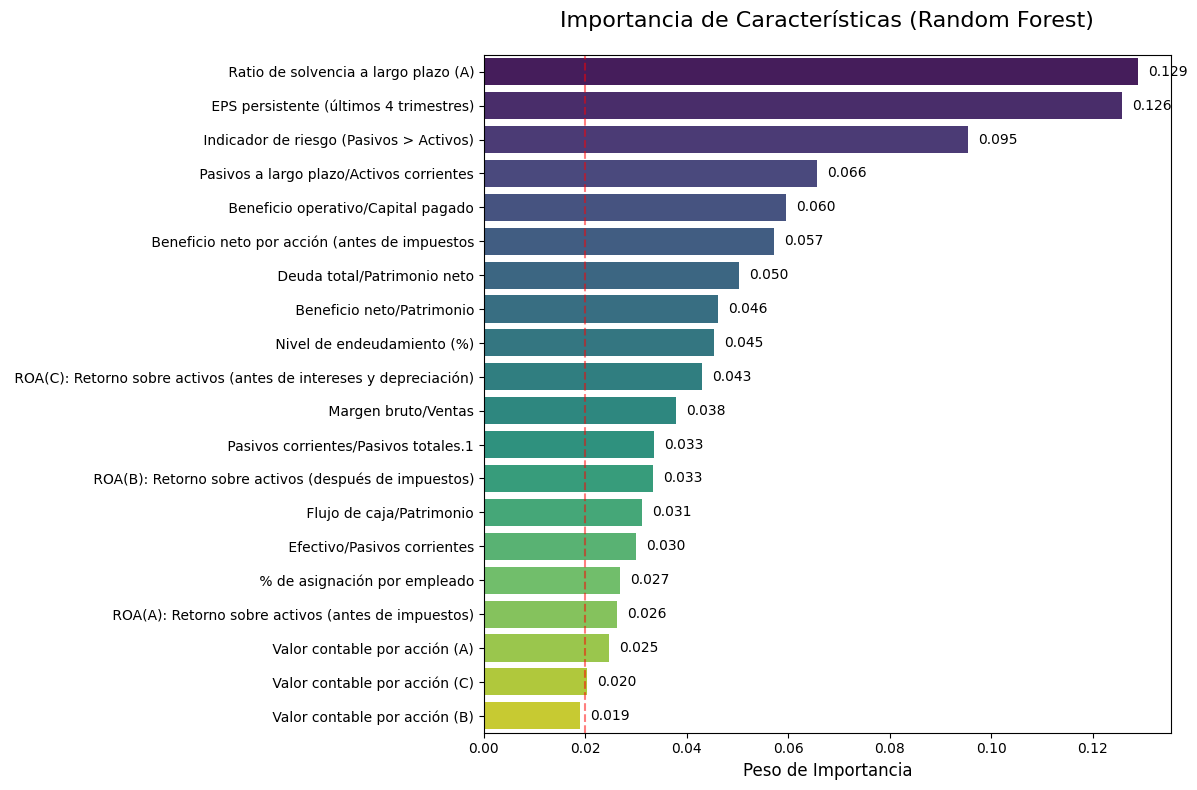


🔍 Insights clave:
--------------------------------------------------
Característica más importante: ' Ratio de solvencia a largo plazo (A)' (Peso: 0.129)
5 primeras características explican el 47.5% de la importancia total


In [31]:
rf_model = model_pipeline.named_steps['rf']
importancias = rf_model.feature_importances_
feat_imp = pd.Series(importancias, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Importancia de Características (Random Forest)', fontsize=16, pad=20)
plt.xlabel('Peso de Importancia', fontsize=12)
plt.ylabel('')
plt.axvline(x=0.02, color='red', linestyle='--', alpha=0.5)

for i, v in enumerate(feat_imp.values):
    ax.text(v + 0.002, i, f"{v:.3f}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🔍 Insights clave:")
print("-" * 50)
print(f"Característica más importante: '{feat_imp.index[0]}' (Peso: {feat_imp.values[0]:.3f})")
print(f"5 primeras características explican el {feat_imp.head(5).sum() * 100:.1f}% de la importancia total")


# Modelo LogisticRegression

📋 Classification Report - Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      1980
           1       0.17      0.86      0.29        66

    accuracy                           0.86      2046
   macro avg       0.58      0.86      0.61      2046
weighted avg       0.97      0.86      0.90      2046

📉 Confusion Matrix


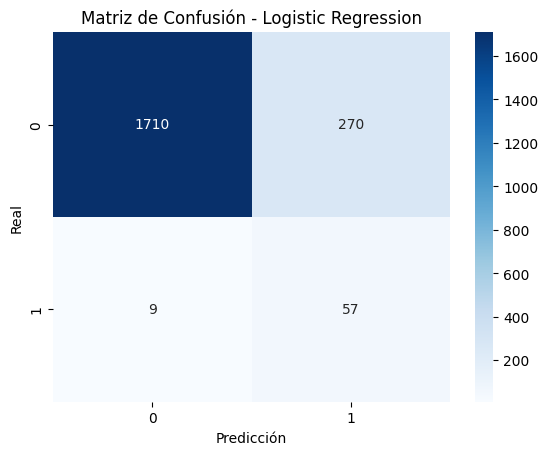

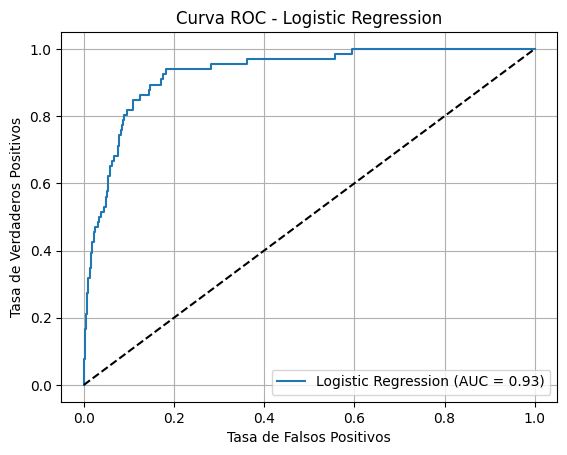

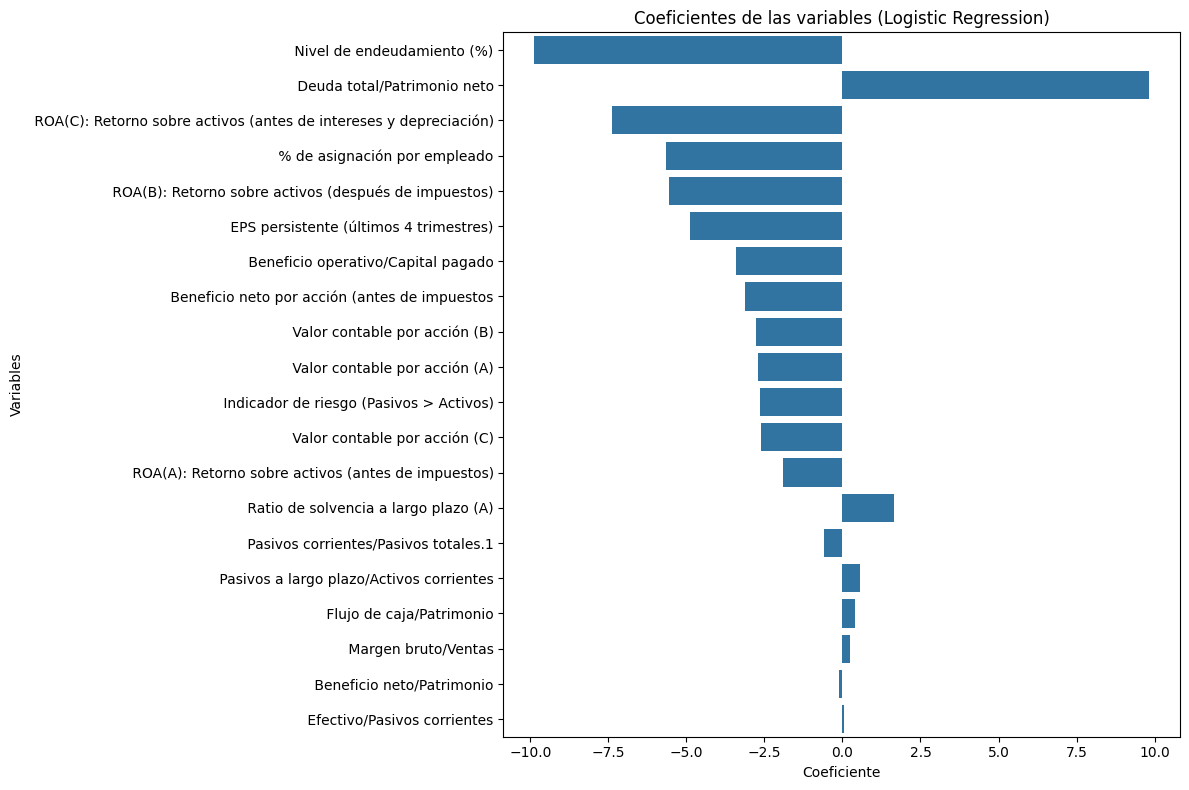

In [32]:
from imblearn.pipeline import Pipeline  # Importar Pipeline desde imblearn
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear el pipeline correcto con SMOTE
lr_pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenamiento
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

# Métricas
print("📋 Classification Report - Logistic Regression")
print(classification_report(y_test, y_pred_lr))

# Matriz de Confusión
print("📉 Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Logistic Regression")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - Logistic Regression')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()

# Importancia de variables vía coeficientes
lr_model = lr_pipeline.named_steps['lr']
coef = lr_model.coef_[0]
feat_coef = pd.Series(coef, index=selected_features).sort_values(key=abs, ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feat_coef, y=feat_coef.index)
plt.title('Coeficientes de las variables (Logistic Regression)')
plt.xlabel('Coeficiente')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


# Modelo XGBOOST

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📋 Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1980
           1       0.29      0.61      0.39        66

    accuracy                           0.94      2046
   macro avg       0.64      0.78      0.68      2046
weighted avg       0.96      0.94      0.95      2046

📉 Confusion Matrix


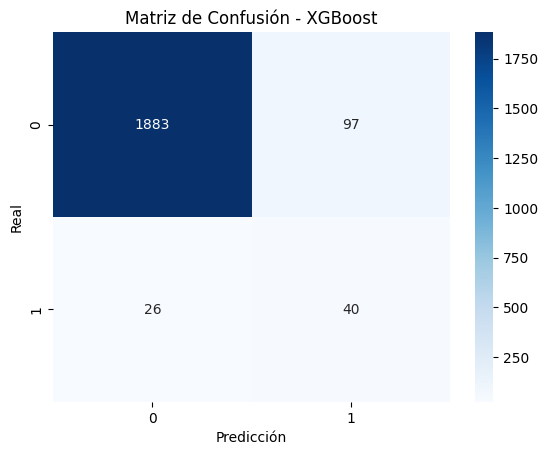

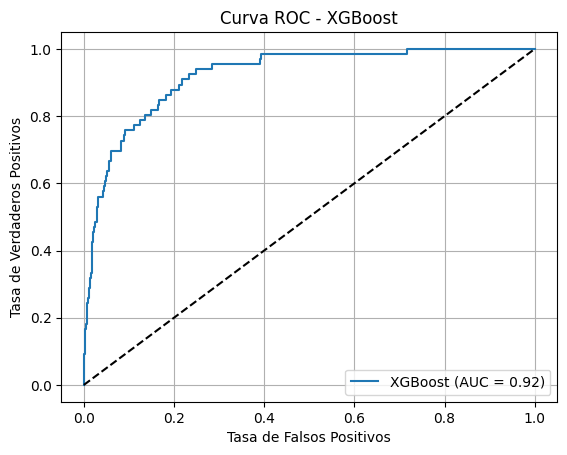

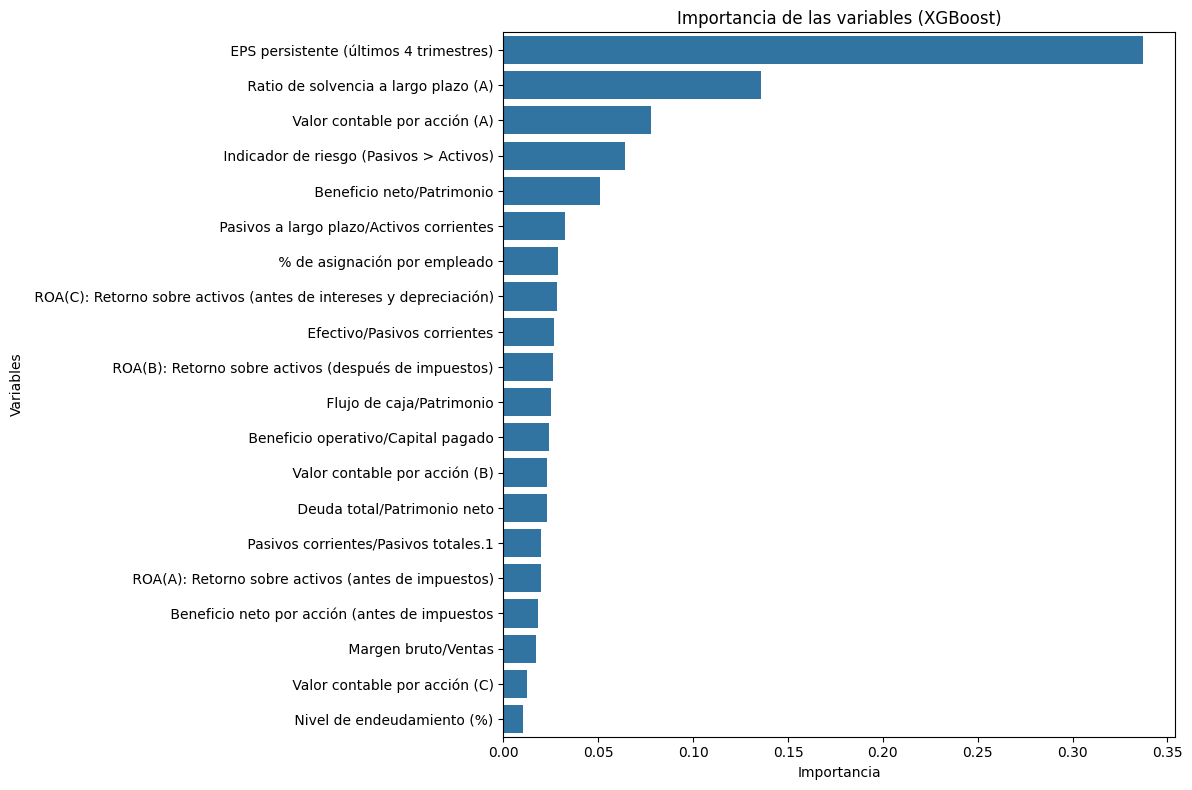

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear el pipeline con SMOTE y XGBoost
xgb_pipeline = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Entrenar el modelo
xgb_pipeline.fit(X_train, y_train)
y_pred_xgb = xgb_pipeline.predict(X_test)
y_proba_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Métricas
print("📋 Classification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb))

# Matriz de Confusión
print("📉 Confusion Matrix")
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - XGBoost")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC - XGBoost')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend()
plt.grid()
plt.show()

# Importancia de variables
xgb_model = xgb_pipeline.named_steps['xgb']
importancias_xgb = xgb_model.feature_importances_
feat_imp_xgb = pd.Series(importancias_xgb, index=selected_features).sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feat_imp_xgb, y=feat_imp_xgb.index)
plt.title('Importancia de las variables (XGBoost)')
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.tight_layout()
plt.show()


# Comparamos modelos con validacion cruzada

In [34]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Diccionario con los modelos
models = {
    'Random Forest': rf_pipeline,
    'Logistic Regression': lr_pipeline,
    'XGBoost': xgb_pipeline
}

# Evaluación
scoring_metric = 'roc_auc'  # podés usar también: 'f1', 'accuracy', 'precision', etc.

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_metric)
    print(f"🔍 {name} - {scoring_metric.upper()} (5-fold CV):")
    print(f"  Mean: {scores.mean():.4f} | Std: {scores.std():.4f}")
    print("-" * 40)


🔍 Random Forest - ROC_AUC (5-fold CV):
  Mean: 0.9113 | Std: 0.0171
----------------------------------------
🔍 Logistic Regression - ROC_AUC (5-fold CV):
  Mean: 0.9276 | Std: 0.0092
----------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:04:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

🔍 XGBoost - ROC_AUC (5-fold CV):
  Mean: 0.9069 | Std: 0.0180
----------------------------------------


# Optimización de modelos

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform


**Optimizando modelo RF**

In [39]:
from scipy.stats import randint

# Definimos rangos para parametros
rf_param_dist = {
    'random_forest__n_estimators': randint(50, 120),  # árboles entre 50 y 120
    'random_forest__max_depth': randint(3, 10),      # profundidad entre 3 y 10
    'random_forest__min_samples_split': randint(2, 5),
    'random_forest__min_samples_leaf': randint(1, 4)
}

rf_random_search = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=rf_param_dist,
    n_iter=10,      # solo 10 combinaciones para que no demore tanto el codigo
    cv=3,           # validación cruzada con 3 folds
    scoring='f1',   # métrica para optimizar
    verbose=2,
    random_state=42,
    n_jobs=-1       # usa todos los núcleos de CPU disponibles
)

rf_random_search.fit(X_train, y_train)

print("Mejores parámetros - Random Forest:", rf_random_search.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejores parámetros - Random Forest: {'random_forest__max_depth': 9, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 4, 'random_forest__n_estimators': 110}


**Optimizando modelo LR**


In [43]:
from scipy.stats import uniform

lr_param_dist_small = {
    'lr__C': [0.1, 1],  # solo 2 valores
    'lr__penalty': ['l2'],  # solo l2 para no probar más
    'lr__solver': ['liblinear']  # solo solver compatible con l2
}

lr_random_search_small = RandomizedSearchCV(
    lr_pipeline,
    param_distributions=lr_param_dist_small,
    n_iter=2,  # pocas combinaciones
    cv=2,  # pocos folds
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

lr_random_search_small.fit(X_train, y_train)
print("Mejores parámetros - Logistic Regression (reducido):", lr_random_search_small.best_params_)


Fitting 2 folds for each of 2 candidates, totalling 4 fits
Mejores parámetros - Logistic Regression (reducido): {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 0.1}


**Optimizando modelo XGB**

In [44]:
xgb_param_dist_small = {
    'xgb__n_estimators': [50, 100],  # menos árboles
    'xgb__max_depth': [3, 5],  # menos profundidad
    'xgb__learning_rate': [0.1, 0.3],  # pocos valores
    'xgb__subsample': [0.8],  # fijo para simplificar
    'xgb__colsample_bytree': [0.8],  # fijo
}

xgb_random_search_small = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=xgb_param_dist_small,
    n_iter=3,  # pocas combinaciones
    cv=2,  # pocos folds
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_random_search_small.fit(X_train, y_train)
print("Mejores parámetros - XGBoost (reducido):", xgb_random_search_small.best_params_)


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Mejores parámetros - XGBoost (reducido): {'xgb__subsample': 0.8, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.8}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [48]:
best_params_rf = rf_random_search.best_params_
best_params_lr = lr_random_search_small.best_params_
best_params_xgb = xgb_random_search_small.best_params_


**Veamos los resultados de las 3 optimizaciones**

In [50]:
print("=== Resultados Optimización ===\n")

print("Random Forest:")
print("Mejores parámetros:", rf_random_search.best_params_)
print("Mejor score (F1):", rf_random_search.best_score_)
print("\n-----------------------------\n")

print("Logistic Regression:")
print("Mejores parámetros:", lr_random_search_small.best_params_)
print("Mejor score (F1):", lr_random_search_small.best_score_)
print("\n-----------------------------\n")

print("XGBoost:")
print("Mejores parámetros:", xgb_random_search_small.best_params_)
print("Mejor score (F1):", xgb_random_search_small.best_score_)
print("\n-----------------------------\n")


=== Resultados Optimización ===

Random Forest:
Mejores parámetros: {'random_forest__max_depth': 9, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 4, 'random_forest__n_estimators': 110}
Mejor score (F1): 0.3928267501605652

-----------------------------

Logistic Regression:
Mejores parámetros: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 0.1}
Mejor score (F1): 0.27991592338794635

-----------------------------

XGBoost:
Mejores parámetros: {'xgb__subsample': 0.8, 'xgb__n_estimators': 100, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.8}
Mejor score (F1): 0.3490566037735849

-----------------------------



# Reentrenamos modelos con los mejores parámetros

In [52]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score, roc_curve, auc
print("Reentrenando modelos con los mejores parámetros encontrados...")

rf_best = rf_pipeline.set_params(**rf_random_search.best_params_)
rf_best.fit(X_train, y_train)

lr_best = lr_pipeline.set_params(**lr_random_search_small.best_params_)
lr_best.fit(X_train, y_train)

xgb_best = xgb_pipeline.set_params(**xgb_random_search_small.best_params_)
xgb_best.fit(X_train, y_train)

Reentrenando modelos con los mejores parámetros encontrados...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:34:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])


Evaluando modelos en el conjunto de test...


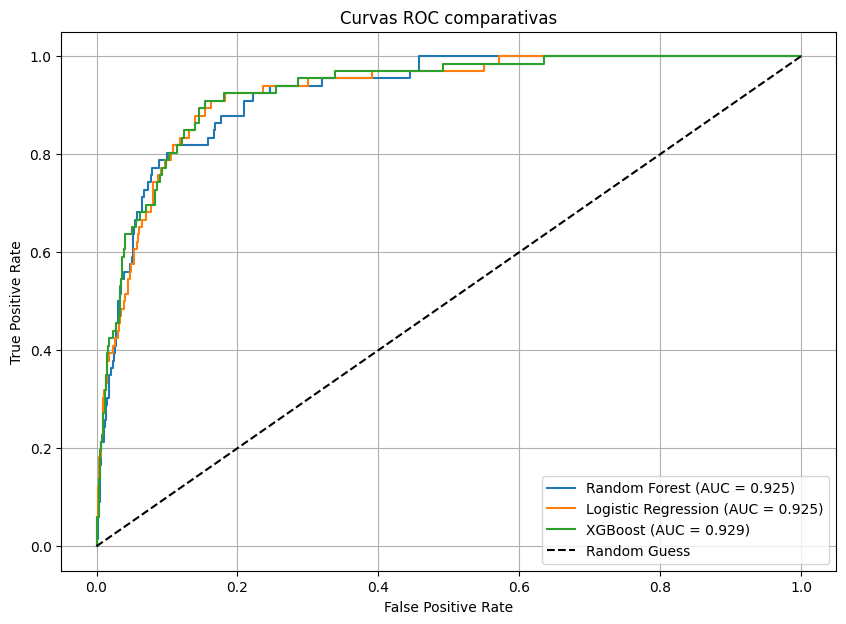

In [53]:
print("\nEvaluando modelos en el conjunto de test...")

models = {
    "Random Forest": rf_best,
    "Logistic Regression": lr_best,
    "XGBoost": xgb_best
}

results = {}

plt.figure(figsize=(10, 7))
plt.title("Curvas ROC comparativas")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]  # probabilidad clase positiva
    y_pred = model.predict(X_test)

    auc_score = roc_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    results[name] = {
        "AUC": auc_score,
        "F1": f1,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec
    }

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Curva ROC línea aleatoria
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.legend()
plt.show()


In [54]:
print("\nResumen de métricas para cada modelo:")
results_df = pd.DataFrame(results).T.sort_values(by="AUC", ascending=False)
display(results_df)


Resumen de métricas para cada modelo:


,AUC,F1,Accuracy,Precision,Recall
XGBoost,0.928658,0.322188,0.891007,0.201521,0.803030
Logistic Regression,0.925429,0.290155,0.866080,0.175000,0.848485
Random Forest,0.924594,0.383673,0.926197,0.262570,0.712121


# Conclusión y comentarios finales 🔚

En este trabajo se abordó el desafío de anticipar la probabilidad de quiebra de empresas utilizando métricas financieras, un tema crítico para bancos, inversores y reguladores que necesitan gestionar riesgos y monitorear la estabilidad financiera sectorial.

Se implementaron y compararon tres modelos de clasificación — Random Forest, Logistic Regression y XGBoost — con el objetivo principal de maximizar la capacidad de detectar empresas en riesgo, priorizando un Recall superior al 85%. Los resultados mostraron que, aunque todos los modelos lograron un excelente desempeño general (AUC > 0.92), ninguno alcanzó aún el umbral deseado de Recall para quiebras, aunque Random Forest mostró el mejor equilibrio entre precisión y detección (Recall ~71%), seguido por XGBoost y Logistic Regression.

El análisis de importancia de variables permitió identificar los factores económicos más críticos que contribuyen a la predicción de riesgo, lo cual aporta valor adicional para la interpretación y toma de decisiones por parte de los distintos actores interesados.


# ⏭ Próximos pasos recomendados

Para avanzar hacia un modelo más efectivo y útil, se recomiendan las siguientes acciones:

1. Intensificar la ingeniería de features y la exploración de nuevas variables financieras y económicas que puedan mejorar la discriminación del modelo

2. Experimentar con técnicas avanzadas de balanceo de clases y modelos ensamblados que puedan aumentar el Recall sin sacrificar la precisión.

3. Ajustar los umbrales de clasificación para priorizar la detección de quiebras, en línea con la importancia del Recall para la audiencia.

4. Validar el desempeño con datos externos y establecer un proceso continuo de monitoreo para asegurar la aplicabilidad en entornos reales.


